In [1]:
import os
import sys
import cv2
import wandb
import gc
import matplotlib.pyplot as plt
import nibabel as nib
import albumentations as A
import numpy as np
import pandas as pd
import seaborn as sns

from time import time

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import models
from torch.cuda.amp import GradScaler, autocast

# Mixed Precision
from torch.cuda.amp import GradScaler, autocast


from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.utils import set_determinism
import monai.transforms as monai_transforms 
from monai.transforms import (Compose,
                              LoadImaged,
                              EnsureChannelFirstd,
                              EnsureTyped,
                              EnsureType,
                              AsDiscrete,
                              Resized,
                              Activations
                             )


from sklearn.metrics import mean_absolute_error
from wandb.keras import WandbCallback

from ipywidgets import interact

from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)

from PIL import Image

gc.collect()

print("Python", sys.version.split(" ")[0])
print("PyTorch", torch.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

!nvidia-smi

Python 3.7.10
PyTorch 1.10.0+cu102
device: cuda:0
Tue Apr  5 00:01:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    16W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

# args

In [82]:
seed = 20
torch.manual_seed(seed)
np.random.seed(seed)
set_determinism(seed)

In [83]:
args = {
    "epochs": 100,  # Epochs num.
    "lr": 1e-3,  # learning rate.
    "batch_size": 16,  # batch size.
    "num_workers": 4,  # batch parallel processes
    "pin_memory": torch.cuda.is_available(),  # speeds up a CPU to GPU memory copy operation
    "classes": 4,
    "one_hot": True,
    "image_size": (256,256)
}

# Funções

## Read files

In [84]:
def read_image(path, is_tensor=False):
    if os.path.basename(path).split(".")[-1] == "nii":
        if is_tensor == True:
            return torch.Tensor(nib.load(path).get_fdata())
        else:
            return nib.load(path).get_fdata()

In [179]:
class MyDataset(torch.utils.data.Dataset):
    """
    Dataset class for read nifti files
    reference: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
    """

    def __init__(self, files, labels, transform=None):
        """
        Parameters:
        -----------
            files [str]: list of paths

            labels [float]: list of labels

            augmentation [dict]
        """
        self.labels = labels
        self.files = files
        self.transform = transform

        if len(self.files) != len(self.labels) or len(self.files) == 0:
            raise ValueError(
                f"Number of source and target images must be equal and non-zero"
            )

    def __len__(self):
        # Denotes the total number of samples"
        return len(self.files)

    def __getitem__(self, index: int):
        # Generates one sample of data

        # Select sample
        img, label = self.files[index], self.labels[index]

        if os.path.basename(img).split(".")[-1] == "nii":
            img = nib.load(img).get_fdata(dtype=np.float32)
            img = np.stack((img,) * 3)  # convert to rgb - out(channels, h, w)
            
            label = nib.load(label).get_fdata(dtype=np.float32)
            label = np.expand_dims(label, 0)
            label = torch.Tensor(label)
#             resize = transforms.Resize(size=(256, 256))
#             img, label = resize(img), resize(label)
        else:
            img = np.load(img).astype(np.float32)
            img = np.stack((img,) * 3)  # convert to rgb - out(channels, h, w)
            
            label = np.load(label).astype(np.float32)
            label = np.expand_dims(label, 0)
            label = torch.Tensor(label)
#             resize = transforms.Resize(size=(256, 256))
#             img, label = resize(img), resize(label)

        # transform
        if self.transform:
            """All pre-trained models expect input images normalized in the same way,
            i.e. mini-batches of 3-channel RGB images of shape (3 x H x W),
            where H and W are expected to be at least 224.
            The images have to be loaded in to a range of [0, 1]
            and then normalized using mean = [0.485, 0.456, 0.406]
            and std = [0.229, 0.224, 0.225]."""

            # move axis - out(h, w, channels)
            img = np.moveaxis(img, 0, -1)
            img = (img - img.min()) / (img.max() - img.min())

            # img = torch.Size([channels, w, h])
            img = self.transform(img)
        resize = transforms.Resize(size=(256, 256))
        img, label = resize(img), resize(label)
        return img, label

# Load Data

In [180]:
# IMAGES_DIR = "/home/jupyter/data/MRBrains18/input_2d"
# MASKS_DIR = "/home/jupyter/data/MRBrains18/target_2d"

IMAGES_DIR = "/home/jupyter/data/MRBrains18/input_2d_4classes"
MASKS_DIR = "/home/jupyter/data/MRBrains18/target_2d_4classes"

In [181]:
images = sorted(
    [
        os.path.join(IMAGES_DIR, x)
        for x in os.listdir(IMAGES_DIR)
        if x != ".ipynb_checkpoints"
    ]
)
masks = sorted(
    [
        os.path.join(MASKS_DIR, x)
        for x in os.listdir(MASKS_DIR)
        if x != ".ipynb_checkpoints"
    ]
)

train_files = [
    {"image": image_name,
     "label": label_name}
    for image_name, label_name in zip(images, masks)
]

print(len(train_files))

336


# Dataset

In [182]:
from torchvision.transforms import transforms

In [183]:
train_params = {
    "batch_size": args['batch_size'],
    "shuffle": True,
    "drop_last": False,
    "num_workers": args['num_workers'],
    "pin_memory":args['pin_memory']
}

post_label = Compose(
    [EnsureType(),
     AsDiscrete(to_onehot=args['classes'])]
)

data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

training_set = MyDataset(images, masks, transform=data_transform)
train_loader = torch.utils.data.DataLoader(training_set, **train_params)

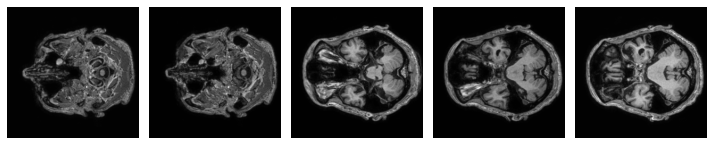

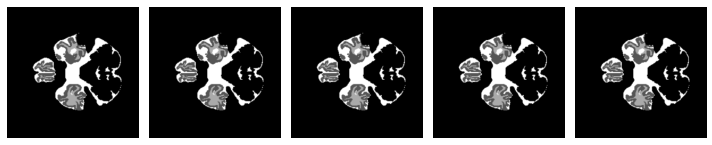

In [185]:
plt.figure(figsize=(10, 4))
for idx in range(5):
    img, label = train_loader.dataset[idx]
    plt.subplot(1, 5, idx+1)
    plt.imshow(img[0, :, :], "gray")
    plt.axis('Off')
    plt.tight_layout()
    
plt.figure(figsize=(10, 4))
for idx in range(5):
    data = train_loader.dataset.__getitem__(idx)
    plt.subplot(1, 5, idx+1)
    plt.imshow(label[0, :, :], "gray")
    plt.axis('Off')
    plt.tight_layout()

## test: one hot encoding

In [186]:
# AsDiscrete = Execute after model forward to transform model output to discrete values

@interact(count=(0, 10 ,1))
def _(count):
    plt.figure(figsize=(10, 4))

    _, label = train_loader.dataset[count]
    X = label.detach().clone()
    X = post_label(X)
    for c in range(args['classes']):
        plt.subplot(2, 5, c+1)
        plt.imshow(X[c, :, :], "gray")
        plt.axis('Off')
        plt.tight_layout()

interactive(children=(IntSlider(value=5, description='count', max=10), Output()), _dom_classes=('widget-intera…

# Prepare model, optimizer and metrics

In [195]:
# RELER
# https://github.com/qubvel/segmentation_models.pytorch
    
import segmentation_models_pytorch as smp
import monai

model = smp.Unet(
    encoder_name = 'resnet34',
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=args['classes'],                     # model output channels (number of classes in your dataset)
#      activation='softmax'
).to(device)

# model = monai.networks.nets.UNet(
#         spatial_dims=2,
#         in_channels=3,
#         out_channels=args['classes'],
#         channels=(16, 32, 64, 128, 256),
#         strides=(2, 2, 2, 2),
# #         num_res_units=2,
#     ).to(device)

# # check keras-like model summary using torchsummary

# ATRIBUIR SOFTMAX
dice_metric = DiceMetric(include_background=False, reduction="mean")
loss_function = DiceLoss(to_onehot_y=args['one_hot'], softmax=True, include_background=False)
optimizer = torch.optim.Adam(model.parameters(), args['lr'])

In [196]:
def get_metric(y_pred, y):
    
    post_trans = Compose([EnsureType(),
                          Activations(softmax=True),
                          AsDiscrete(threshold=0.5)])

    post_label = Compose([EnsureType(),
                          AsDiscrete(to_onehot=args['classes'])])
    
    y_pred = [post_trans(x) for x in decollate_batch(y_pred)]
    y = [post_label(i) for i in decollate_batch(y)]
    
    dice_metric(y_pred=y_pred, y=y)
    metric = dice_metric.aggregate().item()
    return metric

In [197]:
def norm_minmax(img):
    x = img.detach().clone()
    return (x - x.min()) / (x.max() - x.min())

def norm_wholebrain(img):# noise=False):
    # torch.Size([c, sag, cor, axi])
    voxel = img[img > 0]
    mean = voxel.mean()
    std = voxel.std()
    
    # torch.Size([c, sag, cor, axi])
    out = img.detach().clone()
    out[out > 0] = (out[out > 0] - mean)/std
    return out

In [198]:
# for batch_idx, data in enumerate(train_loader):
#     img, label = data
#     img, label = img.to(device), label.to(device)

#     img = norm_wholebrain(img)
    
#     print(img.shape, label.shape)

#     # forward with mixed precision
#     y_pred = model(img)

In [199]:
# label.shape

In [200]:
def train(model, dataloader, optimizer, loss_fn, scaler):
    model.train()

    epoch_loss = []
    dice_score = []
    
    for batch_idx, data in enumerate(dataloader):
        img, label = data
        img, label = img.to(device), label.to(device)

        img = norm_wholebrain(img)
        
        # forward with mixed precision
        with torch.cuda.amp.autocast():
            y_pred = model(img)
            loss = loss_fn(y_pred, label)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        metric = get_metric(y_pred, label)
        dice_score.append(metric)
        dice_metric.reset()

        epoch_loss.append(loss.cpu().data)

    epoch_loss = np.asarray(epoch_loss)

    print("train loss: %.2f\tdice coefficient %.2f" % (epoch_loss.mean(), metric))
    
    results = {"loss": epoch_loss.mean(), "dice": metric}

    return results

# FIT

In [201]:
save_path = '/home/jupyter/models/PyTorch/segmentation/mrbrains/best_metric_model_segmentation2d_dict.pth'

In [202]:
%%time
scaler = torch.cuda.amp.GradScaler()
best_dice = -1

for epoch in range(args["epochs"]):
    if (epoch + 1) % 50 == 0:
        print(f'epoch {epoch+1}/{args["epochs"]}')
        print("--" * 25)
        
        train_results = train(model, train_loader, optimizer, loss_function, scaler)
        dice = train_results['dice']
        
#         if dice > best_dice:
#             best_dice = dice
#             torch.save(model.state_dict(), save_path)
#             print("saved new best metric model")
        torch.save(model, save_path)
        print("--" * 25)
        print("")
        
print("BYE!")

epoch 50/100
--------------------------------------------------
train loss: 0.77	dice coefficient 0.46
--------------------------------------------------

epoch 100/100
--------------------------------------------------
train loss: 0.58	dice coefficient 0.48
--------------------------------------------------

BYE!
CPU times: user 5.3 s, sys: 2.02 s, total: 7.32 s
Wall time: 11.9 s


# LOAD

In [203]:
model = torch.load(save_path)

# INFERENCE

In [204]:
def dice_loss_eval(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)

def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

In [209]:
def inference(dataloader, N: int):
    """
    N: int = sample number
    """
    model.eval()

    img, label = data
    img, label = img.to(device), label.to(device)
    
    img =  norm_wholebrain(img)
    img = img.unsqueeze(0)
    print(img.shape)
    
    y_pred = model(img)

    post_trans = Compose([EnsureType(),
                          Activations(softmax=True),
                          AsDiscrete(threshold=0.5)])

    post_label = Compose([EnsureType(),
                          AsDiscrete(to_onehot=args['classes'])])

    pred = [post_trans(x) for x in decollate_batch(y_pred)]
    label = [post_label(i) for i in decollate_batch(label)]
    
    model.train()
    return {'y_pred': post_trans(pred),
            'y_true': post_label(label)}

# def plot_inference(results: dict):
#     @interact(class_=(0,3,1))
#     def _(class_):
#         plt.figure(figsize=(12, 6))

#         y_pred, y_true = results['y_pred'], results['y_true']
#         plt.subplot(1, 2, 1)
#         plt.title("label")
#         plt.imshow(y_true[class_, :, :].detach().cpu(), cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.title("pred")
#         plt.title('dice loss: {:.2f}\ndice coeff: {:.2f}'.format(
#             dice_loss_eval(y_pred,y_true).item(),
#             dice_coeff(y_pred,y_true).item()))
#         plt.imshow(y_pred[0, class_, :, :].detach().cpu(), cmap="gray");

In [210]:
train_pred = inference(train_loader, 5)
# plot_inference(train_pred)

torch.Size([1, 3, 256, 256])

=== Transform input info -- AsDiscrete ===

=== Transform input info -- AsDiscrete ===
Data statistics:
Type: <class 'torch.Tensor'> torch.float32
Shape: torch.Size([256, 256])
Value range: (0.0, 3.0)
Data statistics:
Type: <class 'torch.Tensor'> torch.float32
Shape: torch.Size([256, 256])
Value range: (0.0, 3.0)


RuntimeError: applying transform <monai.transforms.post.array.AsDiscrete object at 0x7fee5294ea90>

In [289]:
train_pred = inference(train_loader, 10)
plot_inference(train_pred)

interactive(children=(IntSlider(value=1, description='class_', max=3), Output()), _dom_classes=('widget-intera…

# Regression Model

In [23]:
model_encoder = list(model.children())[:-2]

In [24]:
regressor = nn.Sequential(
    *model_encoder,
    nn.Linear(576000, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(device)

loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(regressor.parameters(), args['lr'])

In [316]:
list(regressor.named_children())[1]

('1',
 Sequential(
   (0): Flatten(start_dim=1, end_dim=-1)
   (1): Linear(in_features=576000, out_features=512, bias=True)
   (2): Linear(in_features=512, out_features=128, bias=True)
   (3): Linear(in_features=128, out_features=1, bias=True)
 ))

In [317]:
labels = torch.Tensor([1,2,3,4,5,6])

In [331]:
# EnsureTyped = Ensure the input data to be a PyTorch Tensor or numpy array
train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image", "label"]),
        Resized(keys=["image"], spatial_size=(256,256))
    ]
)



train_files = [
    {"image": image_name,
     "label": label_name}
    for image_name, label_name in zip(images, labels)
]

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds,
                          batch_size=args["batch_size"],
                          num_workers=args["num_workers"],
                          pin_memory=args["pin_memory"],
                          shuffle=True)

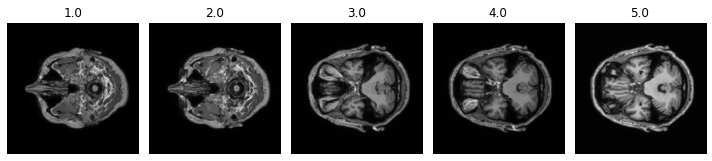

In [319]:
plt.figure(figsize=(10, 4))
for idx in range(5):
    data = train_loader.dataset.__getitem__(idx)
    img, label = data["image"], data["label"]
    plt.subplot(1, 5, idx+1)
    plt.imshow(img[0, :, :], "gray")
    plt.title(label.item())
    plt.axis('Off')
    plt.tight_layout()

In [324]:
def train(model, dataloader, loss_fn, optimizer, scaler):  # , scheduler=False):
    model.train()
    scaler = GradScaler()  # Creates a GradScaler once at the beginning of training.
    start = time()

    epoch_loss, epoch_mae = [], []
    total_mae = 0.0

    for batch_idx, data in enumerate(dataloader):
        img, label = data["image"].to(device), data["label"].to(device)

        label = label.view(label.shape[0], 1)  # torch.Size([32, 1])
        
        # Runs the forward pass with autocasting - Mixed Precision
        # In these regions, CUDA ops run in a dtype chosen by autocast
        # to improve performance while maintaining accuracy.
        with autocast():
            pred = model(img)
            loss = loss_fn(pred, label)
            epoch_loss.append(loss.cpu().data)

        
        # Backpropagation - Mixed Precision
        # Gradient scaling helps prevent gradients with small magnitudes
        # from flushing to zero (“underflowing”) when training with mixed precision.
        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        for pred_, label_ in zip(pred, label):
            #             pred_ = pred_.view(1,-1)
            mae_ = torch.mean(torch.abs(pred_ - label_))
            epoch_mae.append(mae_.cpu().data)

    epoch_loss = np.asarray(epoch_loss)
    epoch_mae = np.asarray(epoch_mae)

    end = time()
    print(
        ("loss:{:.3f}, mae:{:.3f}, Time: {:.2f}s").format(
            epoch_loss.mean(), epoch_mae.mean(), end - start
        )
    )

    results = {"loss": epoch_loss.mean(), "mae": epoch_mae.mean()}
    return results

In [323]:
train(regressor, train_loader, loss_function, optimizer, scaler)

AttributeError: 'list' object has no attribute 'flatten'

In [ ]:
# ADNI_MRBRAINS = '/home/jupyter/data/ADNI/registration'

# adni_data =  [os.path.join(ADNI_MRBRAINS, x)
#               for x in os.listdir(ADNI_MRBRAINS)
#               if x != '.ipynb_checkpoints'][:10]


# adni_files = [
#     {"image": image_name}
#     for image_name in adni_data
# ]


# adni_transforms = Compose(
#     [
#         transforms.LoadImaged(keys=["image"]),
#         transforms.EnsureChannelFirstd(keys=["image"]),
# #         transforms.Orientationd(keys=["image"], axcodes="RAS"),
#         transforms.EnsureTyped(keys=["image"]),
#     ]
# )

# adni_ds = Dataset(data=adni_files, transform=adni_transforms)
# adni_loader = DataLoader(adni_ds,
#                           batch_size=args["batch_size"],
#                           num_workers=args["num_workers"],
#                           pin_memory=args["pin_memory"],
#                           shuffle=True)

In [ ]:
# plt.figure(figsize=(10, 4))
# for idx in range(5):
#     data = adni_loader.dataset.__getitem__(idx)
#     img = data["image"]
#     print(img.shape)
#     plt.subplot(1, 5, idx+1)
#     plt.imshow(img[:, :, 30], "gray")
#     plt.title(label.item())
#     plt.axis('Off')
#     plt.tight_layout()